In [18]:
import pandas as pd
import pickle
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [19]:
def read_dataframe(filename):
    if filename.endswith(".csv"):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    elif filename.endswith(".parquet"):
        df = pd.read_parquet(filename)

    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)

    return df

In [20]:
df_train = read_dataframe("../data/green_tripdata_2021-01.parquet")
df_val = read_dataframe("../data/green_tripdata_2021-02.parquet")

In [21]:
df_train.head()

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2021-01-01 00:15:56   2021-01-01 00:19:52                  N   
1         2  2021-01-01 00:25:59   2021-01-01 00:34:44                  N   
2         2  2021-01-01 00:45:57   2021-01-01 00:51:55                  N   
3         2  2020-12-31 23:57:51   2021-01-01 00:04:56                  N   
7         2  2021-01-01 00:26:31   2021-01-01 00:28:50                  N   

   RatecodeID PULocationID DOLocationID  passenger_count  trip_distance  \
0         1.0           43          151              1.0           1.01   
1         1.0          166          239              1.0           2.53   
2         1.0           41           42              1.0           1.12   
3         1.0          168           75              1.0           1.99   
7         1.0           75           75              6.0           0.45   

   fare_amount  ...  mta_tax  tip_amount  tolls_amount  ehail_fee  \
0          5.5  ...      0.5        0.00           0.0       None   
1         10.0  ...      0.5        2.81           0.0       None   
2          6.0  ...      0.5        1.00           0.0       None   
3          8.0  ...      0.5        0.00           0.0       None   
7          3.5  ...      0.5        0.96           0.0       None   

  improvement_surcharge  total_amount  payment_type  trip_type  \
0                   0.3          6.80           2.0        1.0   
1                   0.3         16.86           1.0        1.0   
2                   0.3          8.30           1.0        1.0   
3                   0.3          9.30           2.0        1.0   
7                   0.3          5.76           1.0        1.0   

   congestion_surcharge  duration  
0                  0.00  3.933333  
1                  2.75  8.750000  
2                  0.00  5.966667  
3                  0.00  7.083333  
7                  0.00  2.316667  

[5 rows x 21 columns]

In [22]:
df_val.head()

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2021-02-01 00:34:03   2021-02-01 00:51:58                  N   
1         2  2021-02-01 00:04:00   2021-02-01 00:10:30                  N   
2         2  2021-02-01 00:18:51   2021-02-01 00:34:06                  N   
3         2  2021-02-01 00:53:27   2021-02-01 01:11:41                  N   
4         2  2021-02-01 00:57:46   2021-02-01 01:06:44                  N   

   RatecodeID PULocationID DOLocationID  passenger_count  trip_distance  \
0         1.0          130          205              5.0           3.66   
1         1.0          152          244              1.0           1.10   
2         1.0          152           48              1.0           4.93   
3         1.0          152          241              1.0           6.70   
4         1.0           75           42              1.0           1.89   

   fare_amount  ...  mta_tax  tip_amount  tolls_amount  ehail_fee  \
0         14.0  ...      0.5       10.00           0.0       None   
1          6.5  ...      0.5        0.00           0.0       None   
2         16.5  ...      0.5        0.00           0.0       None   
3         21.0  ...      0.5        0.00           0.0       None   
4          8.5  ...      0.5        2.45           0.0       None   

  improvement_surcharge  total_amount  payment_type  trip_type  \
0                   0.3         25.30           1.0        1.0   
1                   0.3          7.80           2.0        1.0   
2                   0.3         20.55           2.0        1.0   
3                   0.3         22.30           2.0        1.0   
4                   0.3         12.25           1.0        1.0   

   congestion_surcharge   duration  
0                  0.00  17.916667  
1                  0.00   6.500000  
2                  2.75  15.250000  
3                  0.00  18.233333  
4                  0.00   8.966667  

[5 rows x 21 columns]

In [23]:
df_train["PU_DO"] = df_train["PULocationID"] + "_" + df_train["DOLocationID"]
df_val["PU_DO"] = df_val["PULocationID"] + "_" + df_val["DOLocationID"]

In [24]:
categorical = ["PU_DO"]
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts)

In [25]:
y_train = df_train["duration"].values
y_val = df_val["duration"].values

In [26]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.4793657829373155

In [27]:
with open("models/lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)

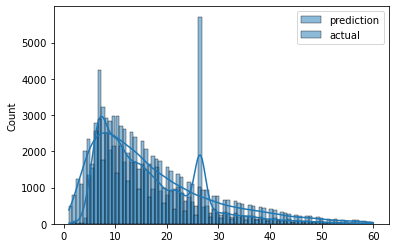

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(y_pred, kde=True, label="prediction")
sns.histplot(y_train, kde=True, label="actual")

plt.legend()
plt.show()